In [ ]:
import numpy as np
import json
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import sys
sys.path.append('../model')
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from modeling_gpt2_rope import GPT2LMHeadModelWithRoPE, GPT2ModelWithRoPE
from configuration_gpt2_rope import GPT2WithRoPEConfig
AutoConfig.register("gpt2-rope", GPT2WithRoPEConfig)
AutoModelForCausalLM.register(GPT2WithRoPEConfig, GPT2LMHeadModelWithRoPE)

In [ ]:
device='cuda:0'
model_path='YOUR_MODEL_PATH'

model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
model=model.eval()
word_embedding = model.lm_head.weight.data
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = model.config.eos_token_id

In [4]:
def get_pe_residual(org_ques,per_ques):
    local_vars = {}
    decoder_temp = tokenizer([org_ques], return_tensors="pt", padding=True)
    decoder_input_ids, decoder_attention_mask = decoder_temp["input_ids"], decoder_temp["attention_mask"]
    decoder_input_ids, decoder_attention_mask = decoder_input_ids.to(device), decoder_attention_mask.to(device)
    with torch.no_grad():
        outputs = model(
            input_ids=decoder_input_ids,
            output_hidden_states=True
        )
    all_hidden_states = outputs['hidden_states']
    exec(org_ques[:-2],local_vars)
    # print(org_ques[:-2])
    gt=str(local_vars[org_ques[-3]]%23)
    # print(gt)
    # print(gt==tokenizer.decode(outputs.logits[0,-1,:].argmax(-1)))
    p_org=outputs.logits[0,-1,:][tokenizer(gt)['input_ids'][0]]

    decoder_temp = tokenizer([per_ques], return_tensors="pt", padding=True)
    decoder_input_ids_, decoder_attention_mask = decoder_temp["input_ids"], decoder_temp["attention_mask"]
    decoder_input_ids_, decoder_attention_mask = decoder_input_ids_.to(device), decoder_attention_mask.to(device)

    with torch.no_grad():
        outputs_ctft = model(
            input_ids=decoder_input_ids_,
            attention_mask=decoder_attention_mask,
            output_hidden_states=True
        )
    all_hidden_states_ctft = outputs_ctft['hidden_states']
    exec(per_ques[:-2],local_vars)
    wrong_gt=str(local_vars[per_ques[-3]]%23)
    # print(wrong_gt)
    # print(wrong_gt==tokenizer.decode(outputs_ctft.logits[0,-1,:].argmax(-1)))
    res=[]
    for layer_to_intervene in range(0, 12):
        cur_layer_res=[]
        # intervene
        for idx in range(0,len(decoder_input_ids_[0])):
            hidden_states = all_hidden_states[layer_to_intervene].clone()
            with torch.no_grad():
                for i in range(layer_to_intervene, 12):
                    if i< layer_to_intervene+2:
                        hidden_states[0, idx:idx+2, :] = all_hidden_states_ctft[i][0, idx:idx+2, :]
                    f_layer = model.transformer.h[i]
                    hidden_states=f_layer(hidden_states)[0]
                hidden_states = model.transformer.ln_f(hidden_states)
                logits_ = torch.matmul(hidden_states, word_embedding.T)
                cur_layer_res.append((p_org.cpu()-logits_[0,-1,tokenizer(gt)['input_ids'][0]].cpu())/np.abs(p_org.cpu()))
        res.append(cur_layer_res)
    return res

In [5]:
def get_pe_subblock(org_ques,per_ques,block='attn'):
    local_vars = {}
    decoder_temp = tokenizer([org_ques], return_tensors="pt", padding=True)
    decoder_input_ids, decoder_attention_mask = decoder_temp["input_ids"], decoder_temp["attention_mask"]
    decoder_input_ids, decoder_attention_mask = decoder_input_ids.to(device), decoder_attention_mask.to(device)
    with torch.no_grad():
        outputs = model(
            input_ids=decoder_input_ids,
            output_hidden_states=True
        )
    all_hidden_states = outputs['hidden_states']
    exec(org_ques[:-2],local_vars)
    # print(org_ques[:-2])
    gt=str(local_vars[org_ques[-3]]%23)
    # print(gt)
    # print(gt==tokenizer.decode(outputs.logits[0,-1,:].argmax(-1)))
    p_org=outputs.logits[0,-1,:][tokenizer(gt)['input_ids'][0]]

    decoder_temp = tokenizer([per_ques], return_tensors="pt", padding=True)
    decoder_input_ids_, decoder_attention_mask = decoder_temp["input_ids"], decoder_temp["attention_mask"]
    decoder_input_ids_, decoder_attention_mask = decoder_input_ids_.to(device), decoder_attention_mask.to(device)

    with torch.no_grad():
        outputs_ctft = model(
            input_ids=decoder_input_ids_,
            attention_mask=decoder_attention_mask,
            output_hidden_states=True
        )
    all_hidden_states_ctft = outputs_ctft['hidden_states']
    exec(per_ques[:-2],local_vars)
    wrong_gt=str(local_vars[per_ques[-3]]%23)
    # print(wrong_gt==tokenizer.decode(outputs_ctft.logits[0,-1,:].argmax(-1)))

    res=[]
    for layer_to_intervene in range(0, 12):
        cur_layer_res=[]
        # intervene
        for idx in range(0,len(decoder_input_ids_[0])):
            hidden_states = all_hidden_states[layer_to_intervene].clone()
            with torch.no_grad():
                for i in range(layer_to_intervene, 12):
                    f_layer = model.transformer.h[i]
                    if i< layer_to_intervene+2:
                        hidden_states_ctft = torch.zeros(all_hidden_states_ctft[i][:, :, :].shape)
                        hidden_states_ctft[...] = all_hidden_states_ctft[i][:, :, :]
                        hidden_states_ctft=hidden_states_ctft.to(device)
                        attn_output_ctft=f_layer.attn(f_layer.ln_1(hidden_states_ctft))[0]
                        hidden_states_ctft=hidden_states_ctft+attn_output_ctft
                        feed_forward_hidden_states_ctft=f_layer.mlp.c_proj(f_layer.mlp.act(f_layer.mlp.c_fc(f_layer.ln_2(hidden_states_ctft))))
                        # attn
                        residual = hidden_states
                        hidden_states = f_layer.ln_1(hidden_states)
                        attn_output = f_layer.attn(hidden_states)[0] 
                        if block=='attn':
                            attn_output[0, idx:idx+2, :]=attn_output_ctft[0, idx:idx+2, :]
                        hidden_states = attn_output + residual
                        # mlp
                        residual = hidden_states
                        hidden_states = f_layer.ln_2(hidden_states)
                        feed_forward_hidden_states = f_layer.mlp.c_proj(f_layer.mlp.act(f_layer.mlp.c_fc(hidden_states)))
                        if block=='mlp':
                            feed_forward_hidden_states[0, idx:idx+2, :]=feed_forward_hidden_states_ctft[0, idx:idx+2, :]
                        hidden_states = residual + feed_forward_hidden_states
                    else:
                        hidden_states=f_layer(hidden_states)[0]
                hidden_states = model.transformer.ln_f(hidden_states)
                logits_ = torch.matmul(hidden_states, word_embedding.T)
                
                cur_layer_res.append((p_org.cpu()-logits_[0,-1,tokenizer(gt)['input_ids'][0]].cpu())/np.abs(p_org.cpu()))
        res.append(cur_layer_res)
    return res

In [6]:
import re  
import random  

def replace_target_number(input_string, which_num=0):  
    matches = list(re.finditer(r'\d+', input_string))  
    
    if len(matches) < 2:  
        return input_string  

    second_number_match = matches[which_num]  
    second_number = second_number_match.group()    
    start, end = second_number_match.span()       

    new_number = second_number  
    while new_number == second_number:  
        new_number = str(random.randint(0, 22))  
    
    output_string = input_string[:start] + new_number + input_string[end:]  

    return output_string  

input_string = "o=21-15\nq=11-o\nk=q+18\nt=9+k\ns=18-t"  
result = replace_target_number(input_string)  
print(result)

o=18-15
q=11-o
k=q+18
t=9+k
s=18-t


In [7]:
def plot_heatmap(res_list):
    data=np.array(res_list)
    data = np.mean(data,0)

    plt.figure(figsize=(6, 3)) 
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", 
                                                    ['#e8f3f9','#41b5c4','#2080b9', '#24429b','#071d59'])
    plt.imshow(data, cmap=cmap, aspect='auto')

    cbar = plt.colorbar()

    cbar.outline.set_visible(False)
    cbar.ax.tick_params(labelsize=12) 

    plt.ylabel('Layer',fontsize=12)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    la = ['Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', '>>']
    la_shifted = ['           ' + label for label in la[:-1]]+['    Q']

    plt.xticks(ticks=np.arange(len(la))*6-0.5, labels=la_shifted,fontsize=12)
    plt.yticks(ticks=np.arange(0,12,2), labels=np.arange(0,12,2),fontsize=12)
    plt.tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.gca().tick_params(axis='y', which='both', length=0)

    rows, cols = data.shape
    for i in range(rows + 1):
        if i>0 and i<rows:
            plt.plot([-0.5, cols - 0.5], [i - 0.5, i - 0.5], color='black', alpha=0.02, linestyle='-', linewidth=0.5)
        else:
            plt.plot([-0.5, cols - 0.5], [i - 0.5, i - 0.5], color='black', alpha=0.02, linestyle='-', linewidth=1)
    for j in range(cols + 1):
        if j>0 and j<cols:
            plt.plot([j - 0.5, j - 0.5], [-0.5, rows - 0.5], color='black', alpha=0.02, linestyle='-', linewidth=0.5)
        else:
            plt.plot([j - 0.5, j - 0.5], [-0.5, rows - 0.5], color='black', alpha=0.02, linestyle='-', linewidth=1)

    plt.show()

In [8]:
with open('../data/test.json') as f:
    testdata=json.load(f)
testdata=[item for item in testdata if item['step']=='6' and item['type']=='test']

100%|██████████| 100/100 [04:36<00:00,  2.77s/it]


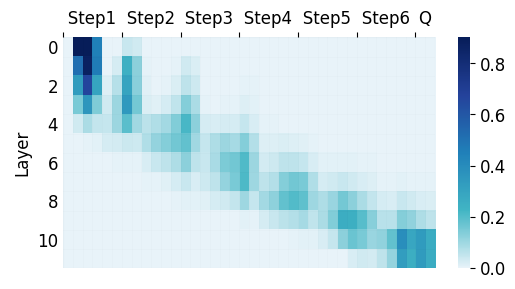

In [9]:
# residual patching
random.seed(0)
res_list=[]
for item in tqdm(testdata[:100]):
    prompt=f"{item['premise']}\n{item['target']}>>"
    res=get_pe_residual(prompt,replace_target_number(prompt))
    res_list.append(res)
plot_heatmap(res_list)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:55<00:00,  3.55s/it]


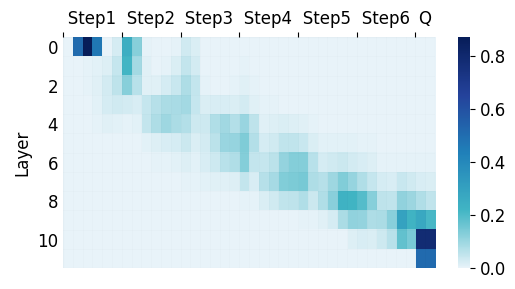

In [10]:
# attn patching
random.seed(0)
res_list=[]
for item in tqdm(testdata[:100]):
    prompt=f"{item['premise']}\n{item['target']}>>"
    res=get_pe_subblock(prompt,replace_target_number(prompt),'attn')
    res_list.append(res)
plot_heatmap(res_list)